The objective of this assignment is to become familiar with the functionality of multilayer perceptron (MLP) neural networks, including their training, evaluation, and the application of regularization, optimization, and related techniques. <br>
The dataset used in this work is the MNIST dataset of handwritten English digits, consisting of 70,000 samples—60,000 for training and 10,000 for testing in its standard form.

# Modules

In [1]:
%pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import copy
import random

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from optuna.trial import TrialState
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader, random_split

from MLP_utils import (
    eval_model,
    plot_metric,
    test_model,
    train_model,
)

# Q1

Split the data into training, validation, and test sets. For validation, you should set aside 10% of the training dataset initially. Then, normalize the data.

## Load Data and Normalization

In [ ]:
def set_seed(seed: int = 42):
    """Set all seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


set_seed(42)

### train and validation set

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [5]:
# Load train data
train_dataset = datasets.MNIST(
    root='dataset/', train=True, transform=transform, download=True)

# 90% for training, 10% for validation
train_size = int(0.9 * len(train_dataset))
valid_size = len(train_dataset) - train_size

# Split the dataset
train_set, val_set = random_split(train_dataset, [train_size, valid_size])

print(f"""number of data samples in training set: {len(train_set)},
number of data samples in validation set: {len(val_set)},""")

number of data samples in training set: 54000,
number of data samples in validation set: 6000,


### test set

In [6]:
# Load test data
test_dataset = datasets.MNIST(
    root='dataset/', train=False, transform=transform, download=True)

print(f"number of data samples in test set: {len(test_dataset)}")

number of data samples in test set: 10000


In [7]:
# Create DataLoaders
train_loader = DataLoader(
    dataset=train_set, batch_size=128, shuffle=True, pin_memory=True)
val_loader = DataLoader(dataset=val_set, batch_size=128,
                        shuffle=False, pin_memory=True)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=128, shuffle=False, pin_memory=True)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Normalized and unnormalized data

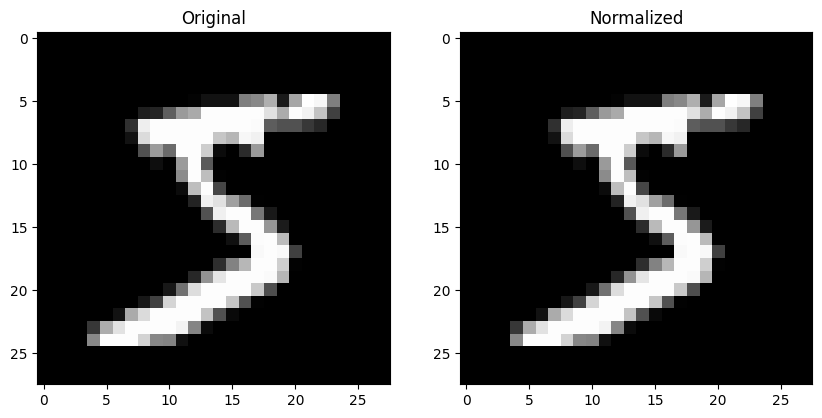

In [9]:
def denormalize(tensor, mean=0.1307, std=0.3081):
    return tensor * std + mean


# Compare images after and before normalization
idx = 0
normalized_img, label = train_dataset[idx]
unnormalized_img = denormalize(normalized_img)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(unnormalized_img.squeeze(), cmap='gray')
axes[0].set_title(f'Original')
axes[1].imshow(normalized_img.squeeze(), cmap='gray')
axes[1].set_title(f'Normalized')
plt.show()

# Q2

+ Use the optimization methods Gradient Descent (GD), Gradient Descent with Momentum, and Adam to train the network. <br>
+ For the training and validation data, plot the loss and accuracy curves over the training phase. <br>
+ To evaluate the performance of the network on the test data, use Precision, Recall, and F1-score metrics for each class. <br>

### Create a fully connected network (MLP)

In [10]:
class MLP(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Optuna: tune learning rate per optimizer

In [15]:
base_model = MLP(input_size=784, num_classes=10).to(device)
init_state_dict = copy.deepcopy(base_model.state_dict())

criterion = nn.CrossEntropyLoss()

In [16]:
def objective(trial, opt_name):
    # Start from the same initial weights for every trial
    model = MLP(input_size=784, num_classes=10).to(device)
    model.load_state_dict(init_state_dict)

    if opt_name == "AD":
        lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
        optimizer = optim.Adam(model.parameters(), lr=lr)

    elif opt_name == "GD_mom":
        lr = trial.suggest_float("lr", 1e-4, 1e-1, log=True)
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    else:
        lr = trial.suggest_float("lr", 1e-4, 1e-1, log=True)
        optimizer = optim.SGD(model.parameters(), lr=lr)

    num_epochs = trial.suggest_int('num_epochs', 10, 20)

    history = train_model(
        model=model,
        optimizer=optimizer,
        criterion=criterion,
        train_loader=train_loader,
        val_loader=val_loader,
        device=device,
        num_epochs=num_epochs,
    )

    val_loss_last = history["val_loss"][-1]
    return val_loss_last

In [ ]:
results = {}

for opt_name in ["AD", "GD_mom", "GD"]:
    print(f"\n=== Optimizing {opt_name} ===")
    study = optuna.create_study(direction="minimize")
    study.optimize(
        lambda trial, opt_name=opt_name: objective(trial, opt_name),
        n_trials=15,
    )

    results[opt_name] = {
        "study": study,
        "best_params": study.best_params,
        "best_value": study.best_value,
    }

[I 2025-12-04 21:12:10,411] A new study created in memory with name: no-name-3272f969-8cc7-4f5a-a107-3ff25c9db6ec



=== Optimizing AD ===


[I 2025-12-04 21:20:08,717] Trial 0 finished with value: 0.18054074565569558 and parameters: {'lr': 7.883388384633498e-05, 'num_epochs': 17}. Best is trial 0 with value: 0.18054074565569558.
[I 2025-12-04 21:26:59,759] Trial 1 finished with value: 0.11597159085671108 and parameters: {'lr': 0.0007000538596925565, 'num_epochs': 18}. Best is trial 1 with value: 0.11597159085671108.
[I 2025-12-04 21:30:07,709] Trial 2 finished with value: 0.16057896121342977 and parameters: {'lr': 0.004607088747236211, 'num_epochs': 16}. Best is trial 1 with value: 0.11597159085671108.
[I 2025-12-04 21:37:31,187] Trial 3 finished with value: 0.13831577501694362 and parameters: {'lr': 0.00013386599918101003, 'num_epochs': 19}. Best is trial 1 with value: 0.11597159085671108.
[I 2025-12-04 21:41:11,565] Trial 4 finished with value: 0.16894994574785233 and parameters: {'lr': 0.007498836561444631, 'num_epochs': 18}. Best is trial 1 with value: 0.11597159085671108.
[I 2025-12-04 21:44:53,249] Trial 5 finished w


=== Optimizing GD_mom ===


[I 2025-12-04 22:33:55,476] Trial 0 finished with value: 0.3062773441473643 and parameters: {'lr': 0.0003603732123243823, 'num_epochs': 12}. Best is trial 0 with value: 0.3062773441473643.
[I 2025-12-04 22:38:33,150] Trial 1 finished with value: 0.10817685697476069 and parameters: {'lr': 0.013433802825094649, 'num_epochs': 17}. Best is trial 1 with value: 0.10817685697476069.
[I 2025-12-04 22:45:14,523] Trial 2 finished with value: 0.22126319030920663 and parameters: {'lr': 0.0008253942418261979, 'num_epochs': 13}. Best is trial 1 with value: 0.10817685697476069.
[I 2025-12-04 22:49:20,598] Trial 3 finished with value: 0.10392179614305497 and parameters: {'lr': 0.015318982731455386, 'num_epochs': 16}. Best is trial 3 with value: 0.10392179614305497.
[I 2025-12-04 22:57:24,409] Trial 4 finished with value: 0.10435189747313658 and parameters: {'lr': 0.004499296100069387, 'num_epochs': 19}. Best is trial 3 with value: 0.10392179614305497.
[I 2025-12-04 23:04:44,800] Trial 5 finished with 


=== Optimizing GD ===


[I 2025-12-04 23:47:04,196] Trial 0 finished with value: 0.106988243440787 and parameters: {'lr': 0.03347713144241232, 'num_epochs': 15}. Best is trial 0 with value: 0.106988243440787.
[I 2025-12-04 23:53:11,311] Trial 1 finished with value: 0.2684522466659546 and parameters: {'lr': 0.0032783367003171022, 'num_epochs': 20}. Best is trial 0 with value: 0.106988243440787.
[I 2025-12-04 23:59:56,778] Trial 2 finished with value: 0.43642910083134967 and parameters: {'lr': 0.0008601120826935778, 'num_epochs': 20}. Best is trial 0 with value: 0.106988243440787.
[I 2025-12-05 00:04:17,854] Trial 3 finished with value: 0.7538619484901429 and parameters: {'lr': 0.0007435354706527396, 'num_epochs': 11}. Best is trial 0 with value: 0.106988243440787.
[I 2025-12-05 00:07:19,169] Trial 4 finished with value: 0.4738704376220703 and parameters: {'lr': 0.0014882490901966128, 'num_epochs': 10}. Best is trial 0 with value: 0.106988243440787.
[I 2025-12-05 00:10:19,425] Trial 5 finished with value: 0.122

In [18]:
print("\nBest per optimizer:")
for opt_name, info in results.items():
    print(opt_name, "->", info["best_params"], "val_loss:", info["best_value"])


Best per optimizer:
AD -> {'lr': 0.0009678080426803175, 'num_epochs': 14} val_loss: 0.10739170470337073
GD_mom -> {'lr': 0.014897378857152904, 'num_epochs': 16} val_loss: 0.10075846656163534
GD -> {'lr': 0.08858451168295718, 'num_epochs': 14} val_loss: 0.09867193633317947


In [19]:
model_Ad = MLP(input_size=784, num_classes=10).to(device)
model_GD_mom = MLP(input_size=784, num_classes=10).to(device)
model_GD = MLP(input_size=784, num_classes=10).to(device)

opt_Ad = optim.Adam(model_Ad.parameters(),
                    lr=results['AD']["best_params"]['lr'])
opt_GD_mom = optim.SGD(model_GD_mom.parameters(),
                       lr=results['GD_mom']["best_params"]['lr'], momentum=0.9)
opt_GD = optim.SGD(model_GD.parameters(),
                   lr=results['GD']["best_params"]['lr'])

### Optimizers comparison

#### Optimizer: Adam

In [20]:
history_Adam = train_model(
    model_Ad, opt_Ad, criterion, train_loader,
    val_loader, device, num_epochs=results['AD']["best_params"]['num_epochs'], pr=True
)

Epoch 1/14 | Train Loss: 0.4003, Train Acc: 0.8882 | Val Loss: 0.2326, Val Acc: 0.9315
Epoch 2/14 | Train Loss: 0.1764, Train Acc: 0.9469 | Val Loss: 0.1679, Val Acc: 0.9510
Epoch 3/14 | Train Loss: 0.1300, Train Acc: 0.9606 | Val Loss: 0.1481, Val Acc: 0.9558
Epoch 4/14 | Train Loss: 0.1036, Train Acc: 0.9686 | Val Loss: 0.1289, Val Acc: 0.9610
Epoch 5/14 | Train Loss: 0.0853, Train Acc: 0.9737 | Val Loss: 0.1271, Val Acc: 0.9612
Epoch 6/14 | Train Loss: 0.0709, Train Acc: 0.9777 | Val Loss: 0.1185, Val Acc: 0.9655
Epoch 7/14 | Train Loss: 0.0613, Train Acc: 0.9809 | Val Loss: 0.1109, Val Acc: 0.9687
Epoch 8/14 | Train Loss: 0.0535, Train Acc: 0.9835 | Val Loss: 0.1158, Val Acc: 0.9642
Epoch 9/14 | Train Loss: 0.0465, Train Acc: 0.9855 | Val Loss: 0.1134, Val Acc: 0.9675


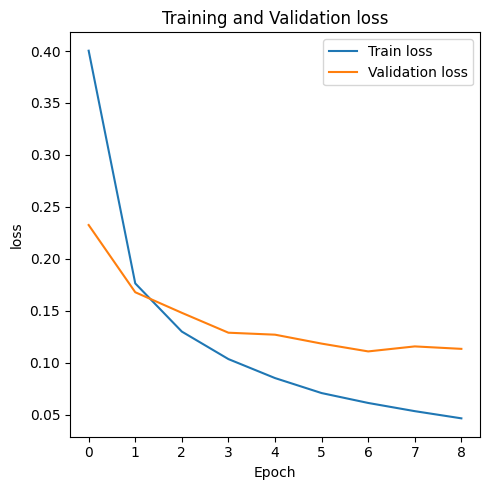

In [21]:
plot_metric(history_Adam["train_loss"], history_Adam["val_loss"], "loss")

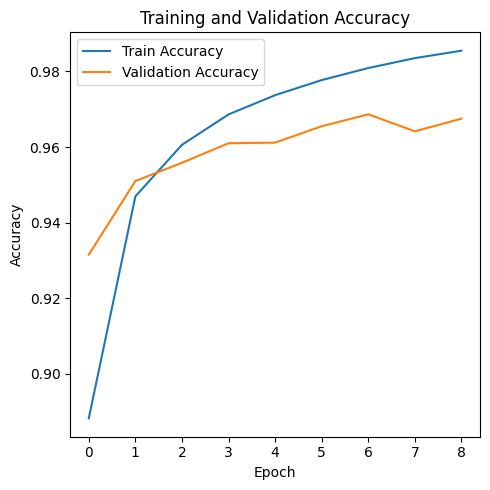

In [22]:
plot_metric(history_Adam["train_acc"],
            history_Adam["val_acc"], label="Accuracy")

In [23]:
y_pred, y_true = test_model(model_Ad, test_loader, device)
report_dict = classification_report(y_true, y_pred, output_dict=True)
df = pd.DataFrame(report_dict).transpose()
print(df)

              precision    recall  f1-score     support
0              0.975855  0.989796  0.982776    980.0000
1              0.986002  0.992952  0.989464   1135.0000
2              0.969844  0.966085  0.967961   1032.0000
3              0.981038  0.973267  0.977137   1010.0000
4              0.928503  0.991853  0.959133    982.0000
5              0.980834  0.975336  0.978078    892.0000
6              0.988335  0.972860  0.980537    958.0000
7              0.968208  0.977626  0.972894   1028.0000
8              0.981270  0.968172  0.974677    974.0000
9              0.981152  0.928642  0.954175   1009.0000
accuracy       0.973800  0.973800  0.973800      0.9738
macro avg      0.974104  0.973659  0.973683  10000.0000
weighted avg   0.974175  0.973800  0.973791  10000.0000


#### Optimizer: Gradient Descent with Momentum

In [24]:
history_GD_mom = train_model(
    model_GD_mom, opt_GD_mom, criterion, train_loader,
    val_loader, device, num_epochs=results['GD_mom']["best_params"]['num_epochs'], pr=True
)

Epoch 1/16 | Train Loss: 0.4358, Train Acc: 0.8667 | Val Loss: 0.2120, Val Acc: 0.9362
Epoch 2/16 | Train Loss: 0.1599, Train Acc: 0.9529 | Val Loss: 0.1578, Val Acc: 0.9527
Epoch 3/16 | Train Loss: 0.1175, Train Acc: 0.9644 | Val Loss: 0.1298, Val Acc: 0.9610
Epoch 4/16 | Train Loss: 0.0905, Train Acc: 0.9721 | Val Loss: 0.1134, Val Acc: 0.9665
Epoch 5/16 | Train Loss: 0.0747, Train Acc: 0.9769 | Val Loss: 0.1058, Val Acc: 0.9692
Epoch 6/16 | Train Loss: 0.0637, Train Acc: 0.9799 | Val Loss: 0.1020, Val Acc: 0.9708
Epoch 7/16 | Train Loss: 0.0537, Train Acc: 0.9831 | Val Loss: 0.1043, Val Acc: 0.9695
Epoch 8/16 | Train Loss: 0.0448, Train Acc: 0.9860 | Val Loss: 0.0994, Val Acc: 0.9717
Epoch 9/16 | Train Loss: 0.0389, Train Acc: 0.9873 | Val Loss: 0.1084, Val Acc: 0.9693
Epoch 10/16 | Train Loss: 0.0338, Train Acc: 0.9891 | Val Loss: 0.0947, Val Acc: 0.9743
Epoch 11/16 | Train Loss: 0.0281, Train Acc: 0.9914 | Val Loss: 0.0930, Val Acc: 0.9753
Epoch 12/16 | Train Loss: 0.0245, Train A

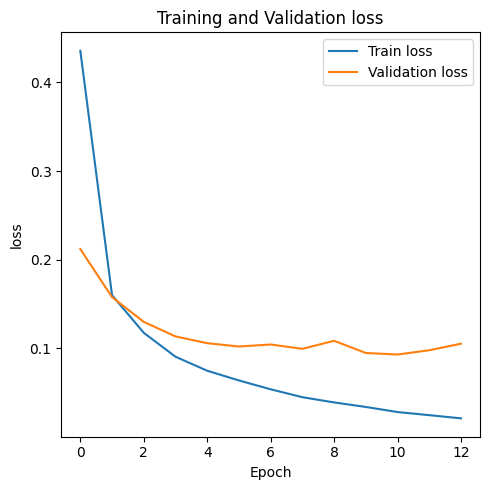

In [25]:
plot_metric(history_GD_mom["train_loss"], history_GD_mom["val_loss"], "loss")

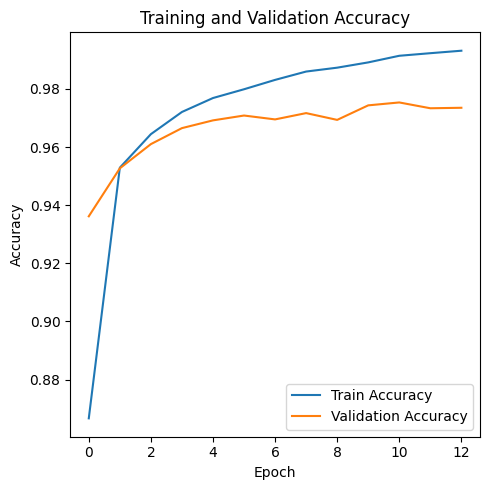

In [26]:
plot_metric(history_GD_mom["train_acc"],
            history_GD_mom["val_acc"], label="Accuracy")

In [27]:
y_pred, y_true = test_model(model_GD_mom, test_loader, device)
report_dict = classification_report(y_true, y_pred, output_dict=True)
df = pd.DataFrame(report_dict).transpose()
print(df)

              precision    recall  f1-score     support
0              0.980711  0.985714  0.983206    980.0000
1              0.990257  0.985022  0.987633   1135.0000
2              0.968391  0.979651  0.973988   1032.0000
3              0.958414  0.981188  0.969667   1010.0000
4              0.984488  0.969450  0.976911    982.0000
5              0.976510  0.978700  0.977604    892.0000
6              0.985154  0.969729  0.977380    958.0000
7              0.982370  0.975681  0.979014   1028.0000
8              0.950505  0.966119  0.958248    974.0000
9              0.973817  0.958375  0.966034   1009.0000
accuracy       0.975100  0.975100  0.975100      0.9751
macro avg      0.975062  0.974963  0.974969  10000.0000
weighted avg   0.975226  0.975100  0.975119  10000.0000


#### Optimizer: GD

In [28]:
history_GD = train_model(
    model_GD, opt_GD, criterion, train_loader,
    val_loader, device, num_epochs=results['GD']["best_params"]['num_epochs'], pr=True
)

Epoch 1/14 | Train Loss: 0.4709, Train Acc: 0.8588 | Val Loss: 0.2490, Val Acc: 0.9257
Epoch 2/14 | Train Loss: 0.1898, Train Acc: 0.9442 | Val Loss: 0.1868, Val Acc: 0.9407
Epoch 3/14 | Train Loss: 0.1383, Train Acc: 0.9586 | Val Loss: 0.1464, Val Acc: 0.9565
Epoch 4/14 | Train Loss: 0.1091, Train Acc: 0.9673 | Val Loss: 0.1347, Val Acc: 0.9592
Epoch 5/14 | Train Loss: 0.0903, Train Acc: 0.9730 | Val Loss: 0.1202, Val Acc: 0.9640
Epoch 6/14 | Train Loss: 0.0775, Train Acc: 0.9759 | Val Loss: 0.1186, Val Acc: 0.9630
Epoch 7/14 | Train Loss: 0.0668, Train Acc: 0.9794 | Val Loss: 0.1149, Val Acc: 0.9633
Epoch 8/14 | Train Loss: 0.0587, Train Acc: 0.9824 | Val Loss: 0.1151, Val Acc: 0.9640
Epoch 9/14 | Train Loss: 0.0522, Train Acc: 0.9836 | Val Loss: 0.1097, Val Acc: 0.9673
Epoch 10/14 | Train Loss: 0.0465, Train Acc: 0.9862 | Val Loss: 0.1095, Val Acc: 0.9668
Epoch 11/14 | Train Loss: 0.0408, Train Acc: 0.9877 | Val Loss: 0.1159, Val Acc: 0.9655
Epoch 12/14 | Train Loss: 0.0364, Train A

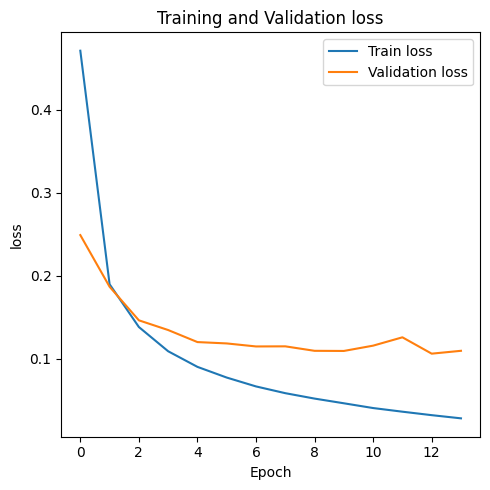

In [29]:
plot_metric(history_GD["train_loss"], history_GD["val_loss"], "loss")

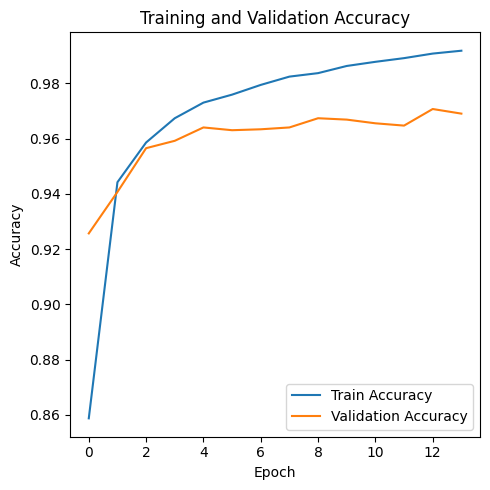

In [30]:
plot_metric(history_GD["train_acc"], history_GD["val_acc"], "Accuracy")

In [31]:
y_pred, y_true = test_model(model_GD, test_loader, device)
report_dict = classification_report(y_true, y_pred, output_dict=True)
df = pd.DataFrame(report_dict).transpose()
print(df)

              precision    recall  f1-score     support
0              0.970942  0.988776  0.979778    980.0000
1              0.982563  0.992952  0.987730   1135.0000
2              0.979146  0.955426  0.967141   1032.0000
3              0.952153  0.985149  0.968370   1010.0000
4              0.959325  0.984725  0.971859    982.0000
5              0.965208  0.964126  0.964666    892.0000
6              0.975078  0.980167  0.977616    958.0000
7              0.984111  0.964008  0.973956   1028.0000
8              0.977918  0.954825  0.966234    974.0000
9              0.975585  0.950446  0.962851   1009.0000
accuracy       0.972300  0.972300  0.972300      0.9723
macro avg      0.972203  0.972060  0.972020  10000.0000
weighted avg   0.972456  0.972300  0.972266  10000.0000
